In [1]:
!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py

--2024-11-14 10:06:01--  https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881 (14K) [text/plain]
Saving to: 'helper_prabowo_ml.py'

helper_prabowo_ml.p 100%[===================>]  13.56K  --.-KB/s    in 0.001s  

2024-11-14 10:06:02 (15.1 MB/s) - 'helper_prabowo_ml.py' saved [13881/13881]



In [2]:
import pandas as pd

In [3]:
train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt",names=['text','emotion'],sep=';',encoding='utf-8')
val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",names=['text','emotion'],sep=';',encoding='utf-8')
test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",names=['text','emotion'],sep=';',encoding='utf-8')

In [4]:
combination_df = pd.concat([train,val,test],axis=0)
combination_df = combination_df.sample(frac=0.1)
combination_df = combination_df.reset_index()
combination_df.head()

,index,text,emotion
0,12934,i bring this up because i am feeling increasin...,love
1,3352,i read too much about discovery and exploratio...,joy
2,2255,ive heard so how are you feeling so many times...,fear
3,5569,i feel like in a way i kinda shocked my body b...,surprise
4,8734,i was so scared it wasnt even funny it just ma...,sadness


In [5]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits

def preprocess_data(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
combination_df = preprocess_data(combination_df,'text')
combination_df.head()

,index,text,emotion
0,12934,bring feeling increasingly nostalgic game ive ...,love
1,3352,read much discovery exploration wild west feel...,joy
2,2255,ve heard feeling times discussed uncertain fut...,fear
3,5569,feel way kinda shocked body changing calorie i...,surprise
4,8734,scared wasnt even funny made feel pathetic stupid,sadness


In [7]:
from sklearn import preprocessing

sentences = combination_df["text"].values
labels = combination_df["emotion"].values
print(f'Number of sentences: {len(sentences)} (same as dataset and labels count)')

le = preprocessing.LabelEncoder()
le.fit(combination_df.emotion)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
numeric_labels = le.transform(combination_df.emotion)
unique_numeric_labels = list(set(numeric_labels))

le_name_mapping

Number of sentences: 2000 (same as dataset and labels count)


{'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}

In [8]:
print(f'Total num: {len(combination_df)}')

Total num: 2000


In [9]:
MAX_SENTENCE_LEN = 0

for seq in sentences:
  if len(seq.split()) > MAX_SENTENCE_LEN:
    MAX_SENTENCE_LEN = len(seq)

MAX_SENTENCE_LEN

58

In [10]:
import torch
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

input_encoded = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,
                        max_length = MAX_SENTENCE_LEN,
                        padding='max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_encoded.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_encoded, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
input_labels = torch.tensor(numeric_labels)

print(f'Number of input token lists: {len(input_ids)}')
print(f'Number of attention masks: {len(attention_masks)}')
print(f'Number of input numeric labels: {len(input_labels)}')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Number of input token lists: 2000
Number of attention masks: 2000
Number of input numeric labels: 2000


In [11]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input_ids, attention_masks, input_labels)
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size)//2
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))
print('{} test samples'.format(test_size))

1600 training samples
200 validation samples
200 test samples


In [12]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Use:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Use: Tesla T4


In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [14]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels = 7,
                                                      output_attentions = False,
                                                      output_hidden_states = False,
                                                    )
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=2e-5)

In [16]:
from transformers import get_linear_schedule_with_warmup

epochs = 7
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [17]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [18]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [19]:
import random
import numpy as np

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)

    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print("Average train accuracy: {0:.2f}".format(avg_train_accuracy))
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Average validation accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    print("Validation Loss: {0:.2f}".format(avg_val_loss))
    print("Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur.': avg_train_accuracy,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 7 ========
Training
  Batch    10  of     50.    Elapsed: 0:00:04.
  Batch    20  of     50.    Elapsed: 0:00:07.
  Batch    30  of     50.    Elapsed: 0:00:10.
  Batch    40  of     50.    Elapsed: 0:00:13.
Average train accuracy: 0.35
Average training loss: 1.68
Training epcoh took: 0:00:15

Running Validation
Average validation accuracy: 0.51
Validation Loss: 1.46
Validation took: 0:00:01

======== Epoch 2 / 7 ========
Training
  Batch    10  of     50.    Elapsed: 0:00:03.
  Batch    20  of     50.    Elapsed: 0:00:06.
  Batch    30  of     50.    Elapsed: 0:00:08.
  Batch    40  of     50.    Elapsed: 0:00:11.
Average train accuracy: 0.56
Average training loss: 1.29
Training epcoh took: 0:00:14

Running Validation
Average validation accuracy: 0.57
Validation Loss: 1.18
Validation took: 0:00:01

======== Epoch 3 / 7 ========
Training
  Batch    10  of     50.    Elapsed: 0:00:03.
  Batch    20  of     50.    Elapsed: 0:00:06.
  Batch    30  of     50.    Elapsed

In [20]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Training Accur.,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,,
1,1.684478,0.351250,1.464719,0.508929,0:00:15,0:00:01
2,1.293426,0.555000,1.181727,0.571429,0:00:14,0:00:01
3,1.051627,0.617500,0.987172,0.736607,0:00:14,0:00:01
4,0.810692,0.748750,0.767309,0.776786,0:00:14,0:00:01
5,0.596953,0.815000,0.616479,0.812500,0:00:15,0:00:01
6,0.459497,0.858125,0.558018,0.830357,0:00:15,0:00:01
7,0.391811,0.888125,0.531023,0.848214,0:00:15,0:00:01


In [21]:
model.save_pretrained(save_directory="finetuned")

----------


In [22]:
batch_size = 32

test_dataloader = DataLoader(
            test_dataset,
            sampler = RandomSampler(test_dataset),
            batch_size = batch_size
        )

In [23]:
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
    
  with torch.no_grad():
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)
    
print('    DONE.')

    DONE.


In [24]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

true_labels = np.concatenate(true_labels, axis=0)

<Axes: >

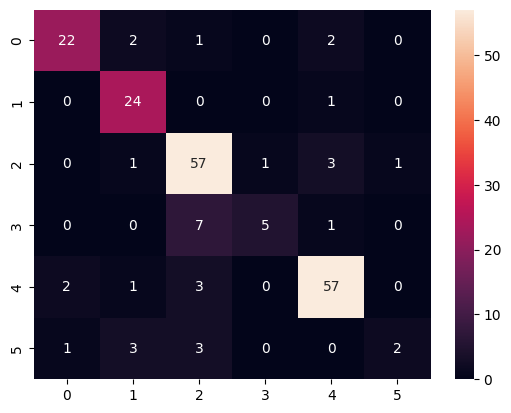

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(true_labels, flat_predictions)
sns.heatmap(cf_matrix, annot=True)

-----

In [26]:
from transformers import TextClassificationPipeline
from transformers import BertTokenizer, AutoModel, BertForSequenceClassification
import numpy as np

map = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}
inv_map = {v: k for k, v in map.items()}

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('/kaggle/input/bertfinetunednews/transformers/twitter/1')

inputs = tokenizer("Reading this book was so exciting", return_tensors="pt")
outputs = model(**inputs)

prediction_logits = outputs.logits.detach().cpu().numpy()[0]

index_max = np.argmax(prediction_logits)
print(f'Emotion: {inv_map[index_max]}')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Emotion: joy
